# Zadanie 4

Korzystając ze zbioru danych dotyczących win przetestować algorytm kosztu-złożoności. Kolejnymi zadaniami są:

1) Wczytanie danych

2) Nazwanie kolumn korzystając z opisu

3) Stworzenie i narysowanie pełnego drzewa (liście z elementami jednej klasy)

4) Sprawdzenie skuteczności pełnego drzewa przez powtórne podstawienie oraz kroswalidację

5) Wybranie optymalnego drzewa wykorzystując tabelę cp: narystować to drzewo oraz porównać wyniki jego skuteczności z pełnym drzewem

6) Stworzenie drzewa dla pierwszych: dwóch, trzech, czterech... itd. zmiennych - za każdym razem wyznaczyć drzewo opytmalne

7) Wykreślenie skuteczności drzewa w funkcjiliczby użytych zmiennych, a także różnice rozmiaru drzewa pełnego i optymalnego

In [1]:
#Najpierw importuję dane i niezbędne biblioteki
import numpy as np
import matplotlib.pyplot as plt
from sklearn import tree

data = np.loadtxt(fname='wine.data', delimiter = ',')
#Nazywam kolejne kolumny: i-ty element wektora nazw odpowiada i-tej kolumnie
columns = ['class', 'alcohol', 'Malic acid', 'Ash', ' Alcalinity of ash', 'Magnesium', 'Total phenols', 
        'Flavanoids', 'Nonfalvanoid phenols', 'Proanthocyanins', 'Color intensity', 'Hue', 
        'OD280/OD315 of diluted wines', 'Proline']

Po wczytaniu danych przejdę do stworzenia drzewa klasyfikującego.

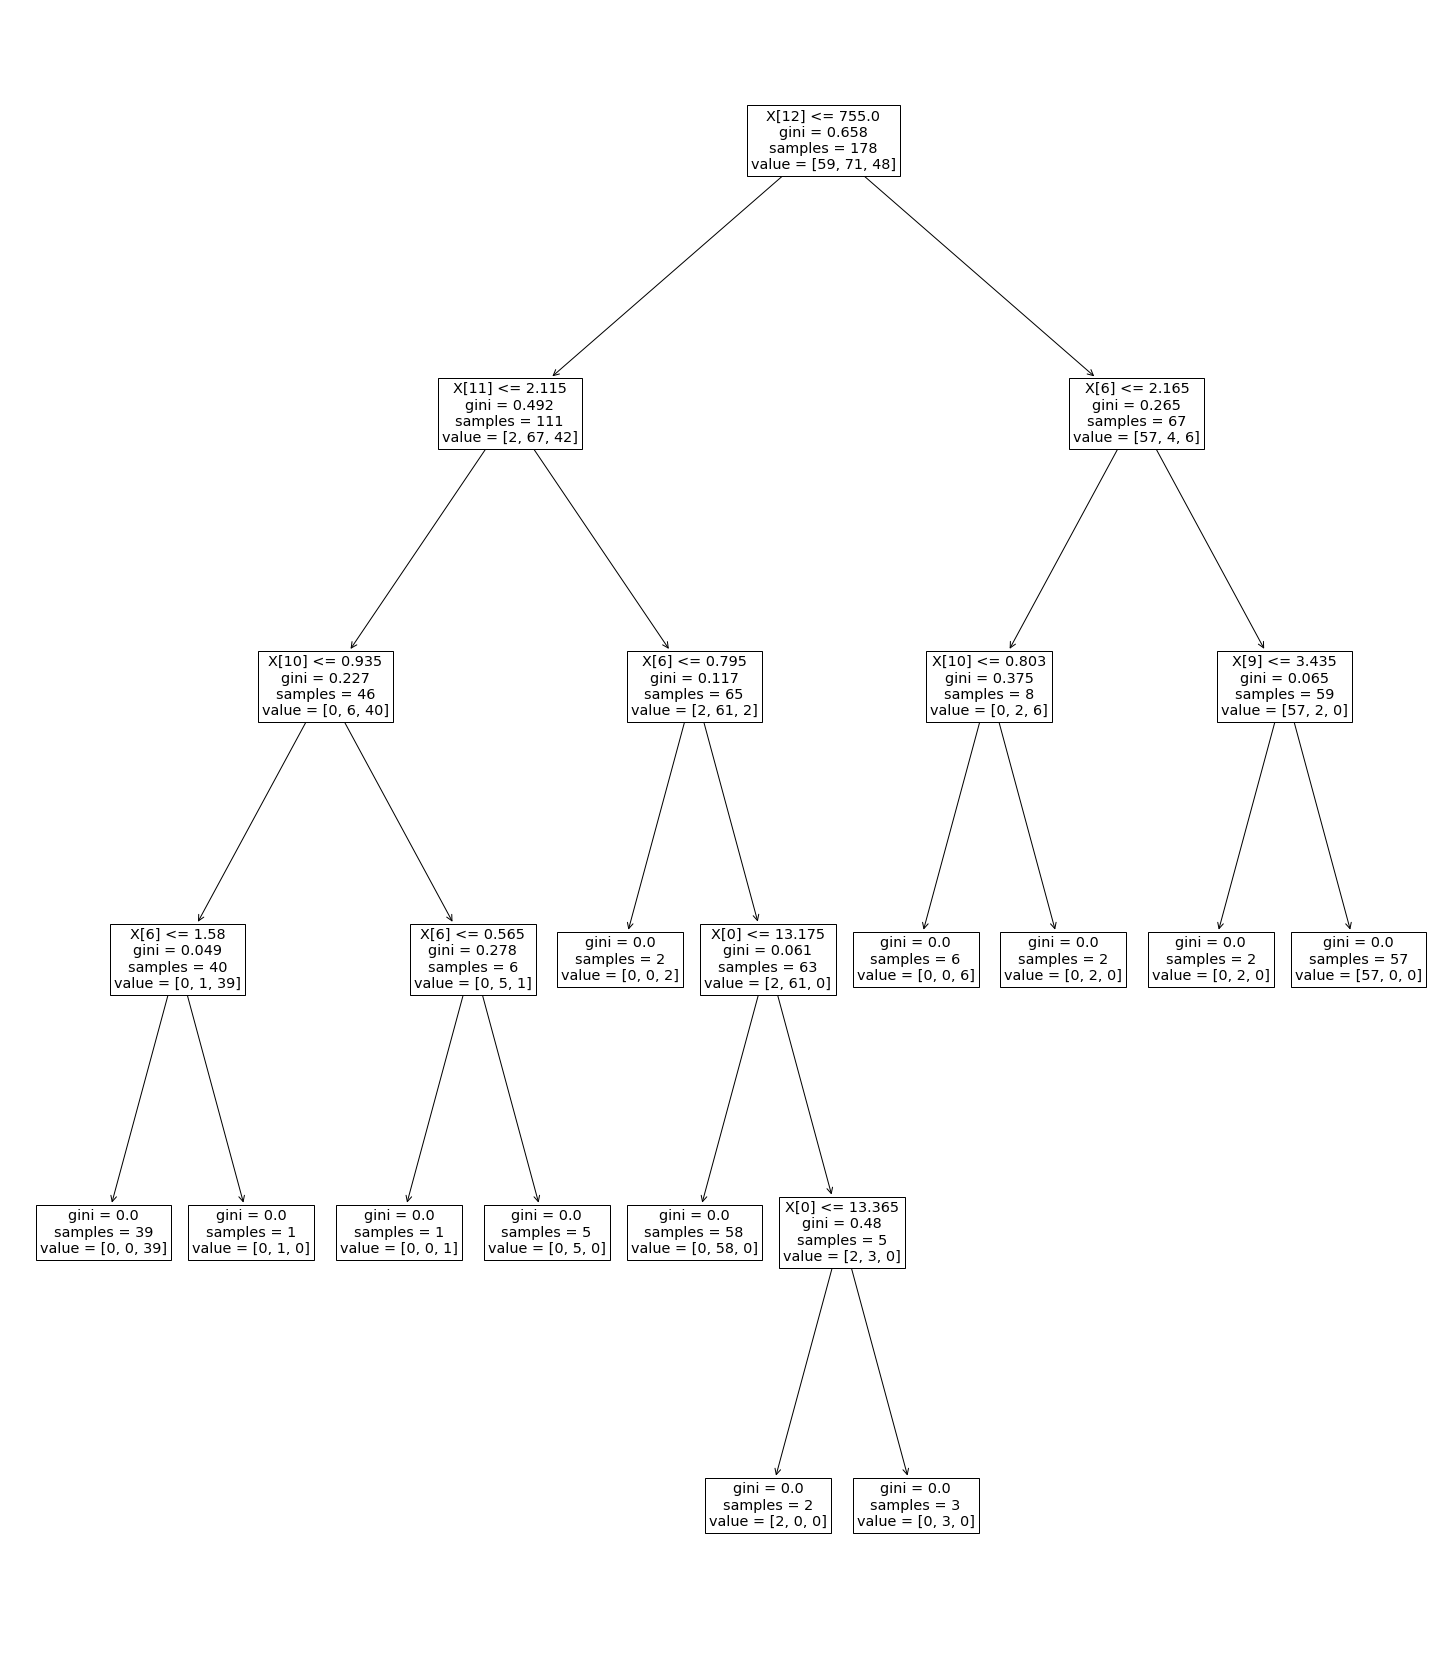

In [2]:
X = data[:, 1:] # Parametry
Y = data[:, 0] # Klasy

clf = tree.DecisionTreeClassifier()
clf = clf.fit(X,Y)

figure = plt.figure(figsize=(25, 30))
tree.plot_tree(clf, fontsize = 'x-large')
plt.show()

Mając stworzone pełne drzewo sprawdzę jego skuteczność najpierw przez powtórne podstawienie, a następnie przez kroswalidację.

In [3]:
# Sprawdzenie przez kroswalidację - wykonam analogicznie do poprzedniego zadania (zad 3)

def cross_tree(X, Y, K, ccp): #X - parametry, Y - klasy, K - liczba podgrup
    
    clf_cross = tree.DecisionTreeClassifier(random_state=0, ccp_alpha=ccp)
    
    # Ułożę dane tak jak zostały zaimportowane, aby je wymieszać
    Y_copy = np.copy(Y); X_copy = np.copy(X)
    data_to_shuffle = np.array([np.append(Y_copy[i], X_copy[i]) for i in range(len(X_copy))])
    np.random.shuffle(data_to_shuffle)
    X_shuf = data_to_shuffle[:, 1:]
    Y_shuf = data_to_shuffle[:, 0]
    
    # Utworzę przedziały i podzielę dane na grupę uczącą i weryfikującą
    periods = np.linspace(0, len(Y_shuf), num=K+1, dtype=int)
    periods = list(zip(periods[:-1], periods[1:]))
    
    # Wektory trafności
    tp_acc_vec = np.array([])
    tn_acc_vec = np.array([])
    
    #Podziel na tyle grupy uczące i weryfikujące - wykonaj tyle razy ile jest grup
    for k in range(len(periods)):
        #Wygeneruj listę indeksów do PU
        indexes=np.array([])
        for p in range(len(periods)):
            if p != k:
                indexes = np.concatenate((indexes, np.arange(periods[p][0], periods[p][1])), axis=None)
        
        # Wybierz elementy o indeksach nienależących do grupy weryfikującej
        X_PU = X_shuf[[int(i) for i in list(indexes)]]
        Y_PU = Y_shuf[[int(i) for i in list(indexes)]]
        
        # Wybierz elementy o indeksach należących do grupy weryfikującej
        X_PW = X_shuf[[int(i) for i in list(np.arange(periods[k][0], periods[k][1]))]] 
        Y_PW = Y_shuf[[int(i) for i in list(np.arange(periods[k][0], periods[k][1]))]]
        
        # Stwórz model a następnie dokonaj predykcji klas z próby weryfikującej 
        clf_cross.fit(X_PU, Y_PU)
        Y_pred = clf_cross.predict(X_PW)
        tp = ((Y_PW==Y_pred) & (Y_PW==1))
        tn = ((Y_PW==Y_pred) & (Y_PW==2))
        
        tp_acc = len(Y_PW[tp])/len(Y_PW[Y_PW==1])
        tn_acc = len(Y_PW[tn])/len(Y_PW[Y_PW==2])
        
        tp_acc_vec = np.append(tp_acc_vec, tp_acc)
        tn_acc_vec = np.append(tn_acc_vec, tn_acc)
    
    # Mając wyniki walidacji dla różnych podgrup te wyniki należy uśrednić
    avg_tp_acc = np.sum(tp_acc_vec)/len(tp_acc_vec)
    avg_tn_acc = np.sum(tn_acc_vec)/len(tn_acc_vec)
    
    # Uwzględnij odchylenie standardowe trafnych klasyfikacji
    acc_sd = np.std(tp_acc_vec)
    
    return np.array([avg_tp_acc, avg_tn_acc, acc_sd])

In [4]:
# Sprawdzenie przez powtórne podstawienie
clf = tree.DecisionTreeClassifier()
clf = clf.fit(X,Y)
Y_pred = clf.predict(X)
tp_pp = (Y == Y_pred)
print("Trafność przy sprawdzeniu przez powtórne podstawienie: ")
print('{:.2f}%\n'.format(len(Y[tp_pp])/len(Y)*100))

# Sprawdzenie przez kroswalidację:
cross_tp, cross_tn, sd = cross_tree(X=X, Y=Y, K=4, ccp=0)
print("Trafność przy sprawdzeniu przez kroswalidację: ")
print('{:.2f}%'.format(cross_tp*100))

Trafność przy sprawdzeniu przez powtórne podstawienie: 
100.00%

Trafność przy sprawdzeniu przez kroswalidację: 
96.15%


Następnie stworzę tabelę cp i wybiorę optymalne drzewo.

Aby to zrobić należy wygenerować szereg drzew o różnej maksymalnej ilości liści, gdzie spośród wielu dostępnych kombinacji drzew o tej samej ilości liści wybierane jest to o największej precyzji.

Algorytm działania:

1) Wyznacz "ścieżkę współczynnika złożoności" - znajdź takie współczynniki dla których zmienia się optymalna ilość liści

2) Metodą kroswalidacji określ średnią dokładność dla każdego drzewa i jej odchylenie standardowe

3) Wybierz optymalne drzewo, czyli takie którego średni bład klasyfikacji mieści się w niepewności (odchylenu standardowym) drzewa o najmniejszym średnim błędzie.

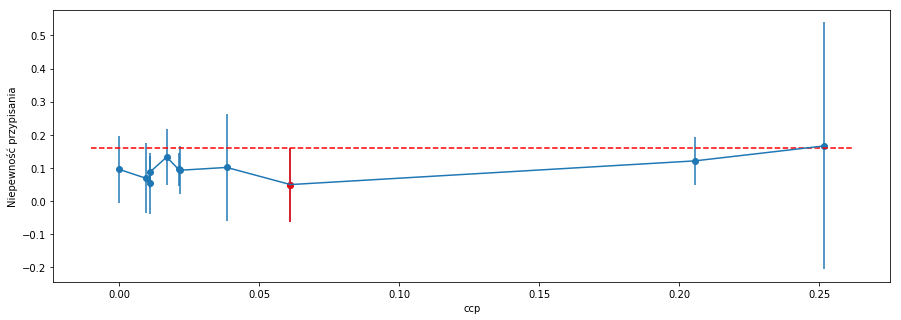

Rozmiary drzew w kolejności odpowiadającej punktom:
[12. 11.  9.  8.  7.  6.  5.  4.  3.  2.  1.]
Optymalna wielkość drzewa: 2.0


In [5]:
# Wyznaczę "ścieżkę współczynnika złożoności" na całym zbiorze
X = data[:, 1:] # Parametry
Y = data[:, 0] # Klasy


clf = tree.DecisionTreeClassifier(random_state=0)
path = clf.cost_complexity_pruning_path(X,Y)
ccps, impurities = path.ccp_alphas, path.impurities

# Przeprowadzę kroswalidację dla każdego z drzew dzieląc zbiór na K części
K = 6
results = np.array([])
for ccp in ccps:
    results = np.append(results, [cross_tree(X=X, Y=Y, K=K, ccp=ccp)])
    
results = results.reshape(len(ccps), 3)
R = 1 - results[:, 0]
sds = results[:, 2]
minR = min(R) # najmniejsze R
ccpminR = ccps[R==minR] # ccp odopwiadające najmniejszemu R


# Zbiorę inofrmację o ilości liści dla każdego ccp
tree_sizes = np.array([])
for ccp in ccps:
    clf_ln = tree.DecisionTreeClassifier(random_state=0, ccp_alpha=ccp)
    clf_ln.fit(X,Y)
    tree_sizes = np.append(tree_sizes, clf_ln.get_n_leaves())

# Znajduję drzewo optymalne
R_min_plus_std = minR + sds[R==minR]
opt_tree_size = min(tree_sizes[R<= R_min_plus_std])

# rysuję odpowiedni wykres dla tych wyników
fig = plt.figure(figsize=(15,5))

plt.scatter(ccps, R)
plt.errorbar(ccps, R, yerr=sds)

plt.scatter(ccpminR, minR, color='red') # Zaznacz najmniejsze R
plt.errorbar(ccpminR, minR, yerr=sds[R==minR], color='red')

# Wykreśl prostą wyznaczającą granicę optymalności
x_sl = np.linspace(0-0.01, max(ccps)+0.01, num=10)
plt.plot(x_sl, np.repeat(R_min_plus_std[0], len(x_sl)), 'r--')

plt.xlabel('ccp')
plt.ylabel('Niepewność przypisania')

plt.show()
print("Rozmiary drzew w kolejności odpowiadającej punktom:")
print(tree_sizes)
print("Optymalna wielkość drzewa: {}".format(opt_tree_size))


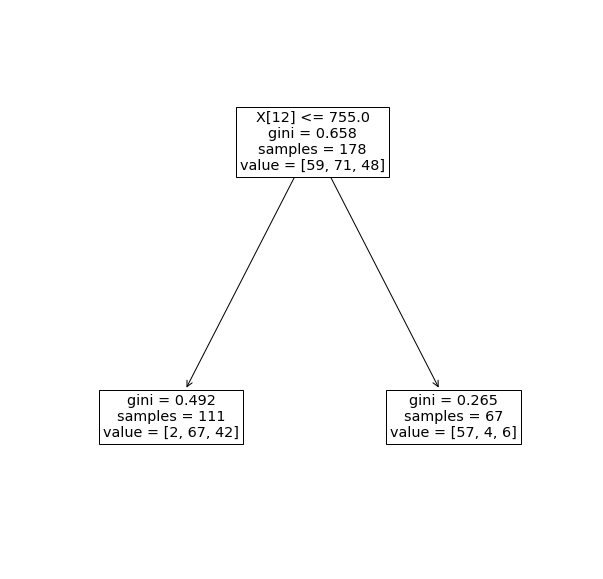

In [6]:
# Wykres drzewa dla optymalnej ilości liści:
clf = tree.DecisionTreeClassifier(max_leaf_nodes = int(opt_tree_size))
clf = clf.fit(X,Y)

figure = plt.figure(figsize=(10, 10))
tree.plot_tree(clf, fontsize = 'x-large')
plt.show()

Analogicznie do powyższego przykładu zdefiniuję funkcję, która robi dokładnie to samo, jednak dla dowolnego zbioru danych. Zdecydowałem się później zdefiniować taką funkcję ponieważ zależało mi na narysowaniu wykresu zbliżonego do tego przedstawionego w przykładzie z lab 6.

In [7]:
def opt_tree(X, Y):
    clf_opt = tree.DecisionTreeClassifier(random_state=0)
    path = clf_opt.cost_complexity_pruning_path(X,Y)
    ccps, impurities = path.ccp_alphas, path.impurities

    # Przeprowadzę kroswalidację dla każdego z drzew dzieląc zbiór na K części
    K = 6
    results = np.array([])
    for ccp in ccps:
        results = np.append(results, [cross_tree(X=X, Y=Y, K=K, ccp=ccp)])

    results = results.reshape(len(ccps), 3)
    R = 1 - results[:, 0]
    sds = results[:, 2]
    minR = min(R) # najmniejsze R
    ccpminR = ccps[R==minR] # ccp odopwiadające najmniejszemu R


    # Zbiorę inofrmację o ilości liści dla każdego ccp
    tree_sizes = np.array([])
    for ccp in ccps:
        clf_ln = tree.DecisionTreeClassifier(random_state=0, ccp_alpha=ccp)
        clf_ln.fit(X,Y)
        tree_sizes = np.append(tree_sizes, clf_ln.get_n_leaves())

    # Znajduję drzewo optymalne
    R_min_plus_std = minR + sds[R==minR]
    opt_tree_size = min(tree_sizes[R<= R_min_plus_std])
    
    clf_opt_tree = tree.DecisionTreeClassifier(random_state=0, max_leaf_nodes = int(opt_tree_size))
    clf_opt_tree.fit(X,Y)
    ccp_opt = ccps[tree_sizes == opt_tree_size]
    
    cross_results = cross_tree(X=X, Y=Y, K=K, ccp=ccp_opt)
    cross_acc_val = cross_results[0]
    
    return [cross_acc_val, clf_opt_tree]
    

In [8]:
for i in [2,3,4]:
    print("Wyniki dla pierwszych", i, 'zmiennych')
    accuracy, clf = opt_tree(X[:, :i], Y)
    print("Trafność: {:.2f}%".format(accuracy*100))

Wyniki dla pierwszych 2 zmiennych
Trafność: 85.16%
Wyniki dla pierwszych 3 zmiennych
Trafność: 85.61%
Wyniki dla pierwszych 4 zmiennych
Trafność: 86.51%


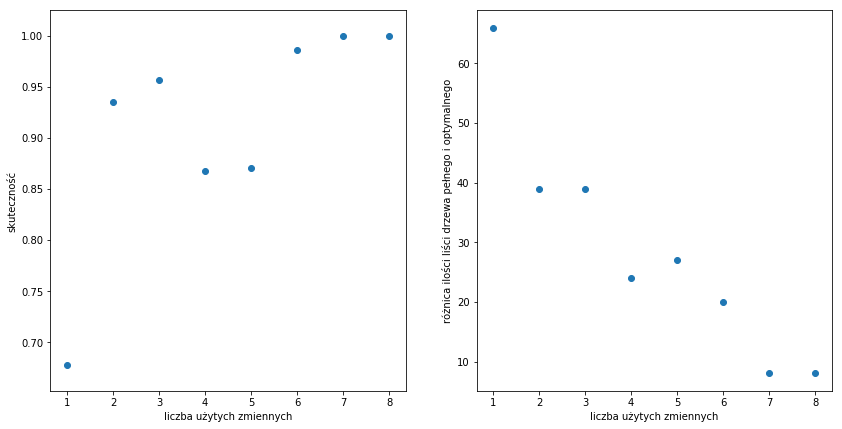

In [14]:
acc_vec = np.array([])
opt_leaves_n = np.array([])
non_opt_leaves_n = np.array([])
zmienne = np.arange(1, 9)
for i in zmienne:
    accuracy, clf = opt_tree(X[:, :i], Y)
    acc_vec = np.append(acc_vec, accuracy)
    
    opt_leaves_n = np.append(opt_leaves_n, clf.get_n_leaves())    
    
    non_opt_clf_el = tree.DecisionTreeClassifier(random_state=0)
    non_opt_clf_el.fit(X[:, :i], Y)
    non_opt_leaves_n = np.append(non_opt_leaves_n, non_opt_clf_el.get_n_leaves())

# Skuteczność drzewa w funkcji liczby użytych zmiennych
figure = plt.figure(figsize=(14,7))
plt.subplot(121)
plt.scatter(zmienne, acc_vec)
plt.xlabel('liczba użytych zmiennych')
plt.ylabel('skuteczność')

# Różnice względem pełnego rozmiaru
plt.subplot(122)
leaves_diff = non_opt_leaves_n - opt_leaves_n
plt.scatter(zmienne, leaves_diff)
plt.xlabel('liczba użytych zmiennych')
plt.ylabel('różnica ilości liści drzewa pełnego i optymalnego')

plt.show()